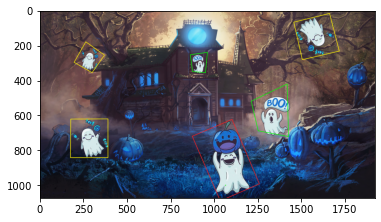

In [25]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def detect(query_img, train_img, train_img_copy, min_matches, my_color): 
    flag=0
    while(flag!=1):
        #Обнаружить на них ключевые точки и вычислить для них любые понравившиеся вам дескрипторы SIFT, SURF, ORB
        orb = cv2.ORB_create(nfeatures=15000)

        features1, des1 = orb.detectAndCompute(query_img, None)
        features2, des2 = orb.detectAndCompute(train_img_copy, None)
        
        #Сопоставить точки шаблона (призрака) с точками изображения через Brute-Force Matching или FLANN Matching и найти какой области соответстветствует призрак
        bf = cv2.BFMatcher(cv2.NORM_HAMMING)
        matches = bf.knnMatch(des1, des2, k = 2)

        good = []    
        good_without_lists = []    
        matches = [match for match in matches if len(match) == 2] 
        for m, n in matches:
            if m.distance < 0.82 * n.distance:
                good.append([m])
                good_without_lists.append(m)

        if len(good) >= min_matches:
            src_pts = np.float32([features1[m.queryIdx].pt for m in good_without_lists]).reshape(-1, 1, 2)
            dst_pts = np.float32([features2[m.trainIdx].pt for m in good_without_lists]).reshape(-1, 1, 2)

            #Найти гомографию используя алгоритм RANSAC. Выделить призрака на изображение рамкой
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,6)

            h, w = query_img.shape[:2]
            pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
            dst = cv2.perspectiveTransform(pts, M)

            m = np.sort(np.reshape(dst.ravel(),(4,2)), axis = 0)
            train_img = cv2.polylines(train_img, [np.int32(dst)], True, my_color, 2, cv2.LINE_AA)
            train_img_copy = cv2.rectangle(train_img_copy, pt1 = tuple(np.int32(m[0])), pt2 = tuple(np.int32(m[3])), color=(0,255,0), thickness=-1)
        else:
            flag=1
    return (train_img, train_img_copy)     

#Загрузка изображения, на котором необходимо осуществлять поиск
train_img = cv2.imread("lab7.png")

#Загрузка изображения(ий) призраков
query_img = cv2.imread("candy_ghost.png")
train_img_copy = train_img.copy()
train_img, train_img_copy = detect(query_img, train_img, train_img_copy, 30, (255,242,0))
#plt.imshow(train_img)
#plt.show()

query_img = cv2.imread("scary_ghost.png")
train_img, train_img_copy = detect(query_img[:,::-1], train_img, train_img_copy, 30, (0,255,0))
#plt.imshow(train_img)
#plt.show()

query_img = cv2.imread("pampkin_ghost.png")
train_img, train_img_copy = detect(query_img, train_img, train_img_copy, 30, (255,30,30))

cv2.imshow("output", cv2.resize(train_img, (960, 540))) 
cv2.waitKey(0)

plt.imshow(train_img)
plt.show()